### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий 

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ № 4


### Дисциплина: Методы машинного обучения

##### Студент:  Пономарева Л. М.
##### Группа:   НПИбд-02-19

## Москва 2022
***

Вариант 2 

1. Считайте котировки акции с указанным ниже тикером за 2020-2021 год: 

 F         Ford Motor Company 

2. Показатель акции: дневной доход, способ визуализации –эмпирическая PDF 

3. Прогнозирование стоимости акции через 5 дней по данным за предыдущие 20 дней. 

4. Показатель качества RMSE 

5. Техника борьбы с исчезающими градиентами: пакетная нормализация

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

#### Задание 1
При помощи модуля `pandas_datareader` считайте котировки указанной в индивидуальным задании акции за указанный период времени. 

Загрузим модуль yfinance для получения биржевых данных с Yahoo! Finance

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Загрузим модуль `pandas_datareader`

In [3]:
from pandas_datareader import data as pdr
import yfinance as yfin
import datetime as dt

yfin.pdr_override()

Загрузим ежедневные котировки акций компании Ford Motor Company за 2020-2021 год:

In [4]:
ford = pdr.get_data_yahoo('F', 
                          start=dt.datetime(2020, 1, 1), 
                          end=dt.datetime(2022, 1, 1))
ford.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,9.29,9.42,9.19,9.42,9.108328,43425700
2020-01-03,9.31,9.37,9.15,9.21,8.905277,45040800
2020-01-06,9.10,9.17,9.06,9.16,8.856931,43372300
2020-01-07,9.20,9.25,9.12,9.25,8.943952,44984100
2020-01-08,9.23,9.30,9.17,9.25,8.943952,45994900


In [5]:
ford.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-27,20.260000,20.889999,20.100000,20.799999,20.556833,59651800
2021-12-28,20.660000,21.059999,20.590000,20.760000,20.517302,53020500
2021-12-29,20.709999,20.770000,20.450001,20.559999,20.319639,37883000
2021-12-30,20.590000,20.959999,20.469999,20.469999,20.230692,51470100
2021-12-31,20.459999,21.010000,20.459999,20.770000,20.527185,51899600


#### Задание 2 
Визуализируйте котировки акции (столбец `Adj Close`) за весь период на графике. Подпишите оси и рисунок.

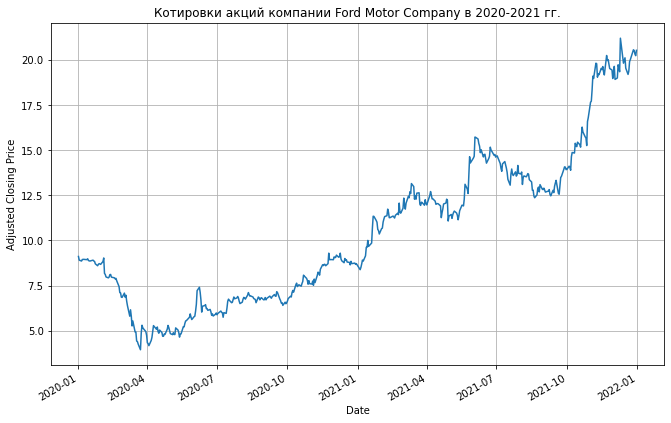

In [6]:
ford['Adj Close'].plot.line(ylabel='Adjusted Closing Price', grid=True, figsize = (11, 7), title='Котировки акций компании Ford Motor Company в 2020-2021 гг.');

#### Задание 3. 
Вычислите и визуализируйте показатель акции заданный в индивидуальном задании.

Показатель акции: дневной доход, способ визуализации – эмпирическая CDF 

In [7]:
d_close = ford[['Adj Close']]
d_close

,Adj Close
Date,
2020-01-02,9.108328
2020-01-03,8.905277
2020-01-06,8.856931
2020-01-07,8.943952
2020-01-08,8.943952
...,...
2021-12-27,20.556833
2021-12-28,20.517302
2021-12-29,20.319639


__Дневной доход__ по акции равен разности текущей цены акции и цены предыдущего дня.  
Создадим функцию реализующую подсчет дневного дохода:

In [8]:
def daily_return(prices):
    return prices - prices.shift(1)

Подсчитаем дневной доход для каждого дня. Для первого дня установим значения в 0.

In [9]:
d_r = daily_return(d_close)
d_r.fillna(0, inplace=True)
d_r

,Adj Close
Date,
2020-01-02,0.000000
2020-01-03,-0.203051
2020-01-06,-0.048347
2020-01-07,0.087021
2020-01-08,0.000000
...,...
2021-12-27,0.543570
2021-12-28,-0.039532
2021-12-29,-0.197662


Эмпирическая функция распределения:

In [10]:
def ECDF(data, x):
    counter = 0
    for v in data:
        if v <= x:
            counter += 1
    return counter / len(data)

In [11]:
prices = d_r['Adj Close']
npoints = 1000
dx = (prices.max()-prices.min())/npoints

xlist = [prices.min()+dx*i for i in range(npoints)]
ylist = [ECDF(prices, x) for x in xlist]

Итоговое распределение:

In [12]:
df_ECDF = pd.DataFrame(ylist, columns=['Распределение'], index=xlist)
df_ECDF

,Распределение
-1.150530,0.00198
-1.147521,0.00198
-1.144513,0.00198
-1.141504,0.00198
-1.138496,0.00198
...,...
1.842980,0.99802
1.845988,0.99802
1.848997,0.99802
1.852006,0.99802


Визуализируем график эмпирической функции распределения:

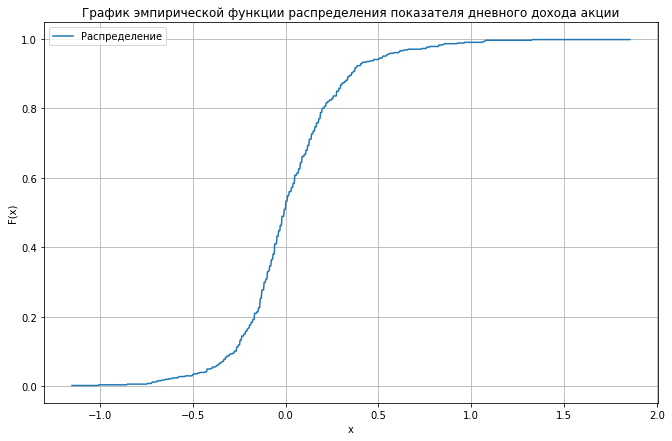

In [13]:
df_ECDF.plot.line(title='График эмпирической функции распределения показателя дневного дохода акции', xlabel="x", ylabel="F(x)", figsize = (11, 7), grid=True);

#### Задание 4
Сформируйте обучающую, тестовую и валидационные выборки для обучения нейронной сети в соответствии с индивидуальным заданием.  

Прогнозирование стоимости акции через 5 дней по данным за предыдущие 20 дней. 

In [14]:
ford.shape

(505, 6)

Используем первые 50% данных в наборе для обучения, следующие 25% для валидации и последние 25% для тестирования. Вычислим количество записей в обучающей, валидационной и тестовой выборках: 

In [15]:
train_size = int(0.5 * len(ford))
val_size = int(0.25 * len(ford))
test_size = len(ford) - train_size - val_size
print("train_size", train_size)
print("val_size:", val_size)
print("test_size:", test_size)

train_size 252
val_size: 126
test_size: 127


Используем `timeseries_dataset_from_array()` для создания трех наборов данных (объектов `BatchDataset`) – для обучения, для валидации и для тестирования со следующими значениями параметров:

* `sample_rate = 1` — наблюдения будут производиться каждый день;
* `sequence_length=20` — наблюдения будут браться за 20 дней;
* `delay=sampling_rate*(sequence_length+20-1)` — целью для входной последовательности будет цена через 5 дней после окончания последовательности;

При создании набора обучающих данных передадим в функцию аргементы `start_index = 0` и `end_index = train_size`, чтобы использовать только первые 50% данных. Для набора данных валидации передадим в функцию `start_index = train_size` и `end_index = train_ize + val_size`, чтобы использовать следующие 25% данных. Наконец, для тестового набора данных передадим `start_index=train_size+val_size`, чтобы использовать оставшиеся данные.

In [16]:
sampling_rate = 1
sequence_length = 20
delay = sampling_rate * (sequence_length + 5 - 1)
batch_size = 64

train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    ford[:-delay],
    targets=prices[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=train_size)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    ford[:-delay],
    targets=prices[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=train_size,
    end_index=train_size + val_size)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    ford[:-delay],
    targets=prices[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=train_size + val_size)

Посмотрим на размеры первого пакета:

In [17]:
for samples, targets in train_dataset:
    print("Форма признаков:", samples.shape)
    print("Форма откликов:", targets.shape)
    break

Форма признаков: (64, 20, 6)
Форма откликов: (64,)


#### Задание 5
Постройте нейронную сеть MLP с нормализующим слоем и одним плотным скрытым слоем из 16 нейронов для прогнозирования стоимости акции и обучите ее на обучающей выборке. Оцените качество прогнозирования при помощи заданного показателя качества на тестовой выборке.

Показатель качества RMSE.

Создадим нормализующий слой, адаптируем для обучающей выборки:

In [18]:
normalization_layer = tf.keras.layers.Normalization(axis=None,input_shape=(ford.shape[1],)) 
normalization_layer.adapt(ford[:train_size])

Создадим нейронную сеть MLP с нормализующим слоем и одним плотным скрытым слоем и обучим ее на обучающей выборке:

In [19]:
inputs = tf.keras.Input(shape=(sequence_length, ford.shape[-1]))
x = normalization_layer(inputs)
x = tf.keras.layers.Dense(16, activation="relu")(x)
outputs = tf.keras.layers.Dense(1)(x)

model_mlp = tf.keras.Model(inputs, outputs)

model_mlp.compile(optimizer="rmsprop", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model_mlp.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                   ) 

Epoch 1/5
4/4 [==============================] - 1s 92ms/step - loss: 0.0780 - root_mean_squared_error: 0.2829 - val_loss: 0.1432 - val_root_mean_squared_error: 0.3811
Epoch 2/5
4/4 [==============================] - 0s 36ms/step - loss: 0.0560 - root_mean_squared_error: 0.2340 - val_loss: 0.1304 - val_root_mean_squared_error: 0.3663
Epoch 3/5
4/4 [==============================] - 0s 29ms/step - loss: 0.0509 - root_mean_squared_error: 0.2242 - val_loss: 0.1241 - val_root_mean_squared_error: 0.3627
Epoch 4/5
4/4 [==============================] - 0s 33ms/step - loss: 0.0488 - root_mean_squared_error: 0.2217 - val_loss: 0.1224 - val_root_mean_squared_error: 0.3441
Epoch 5/5
4/4 [==============================] - 0s 30ms/step - loss: 0.0485 - root_mean_squared_error: 0.2225 - val_loss: 0.1220 - val_root_mean_squared_error: 0.3551


In [20]:
print(f"RMSE на тестовом наборе: {model_mlp.evaluate(test_dataset)[1]:.2f}")

2/2 [==============================] - 0s 9ms/step - loss: 0.1468 - root_mean_squared_error: 0.4010
RMSE на тестовом наборе: 0.40


In [21]:
model_mlp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 6)]           0         
                                                                 
 normalization (Normalizatio  (None, 20, 6)            3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 20, 16)            112       
                                                                 
 dense_1 (Dense)             (None, 20, 1)             17        
                                                                 
Total params: 132
Trainable params: 129
Non-trainable params: 3
_________________________________________________________________


Создадим переменные необходимые для будущей визуализации получившихся данных:

In [22]:
loss_mlp = np.true_divide(history.history["root_mean_squared_error"], history.history["root_mean_squared_error"][0])
val_loss_mlp = np.true_divide(history.history["val_root_mean_squared_error"], history.history["val_root_mean_squared_error"][0])

In [23]:
trainPredict_mlp = model_mlp.predict(train_dataset)
testPredict_mlp = model_mlp.predict(test_dataset)

#### Задание 6
Примените указанную в индивидуальном задании технику решения проблемы исчезающих градиентов и постройте нейронную сеть MLP с нормализующим слоем и тремя плотными скрытыми слоями из 16 нейронов для прогнозирования стоимости акции и обучите ее на обучающей выборке. Оцените качество прогнозирования при помощи заданного показателя качества для тестовой выборки.

Техника борьбы с исчезающими градиентами: пакетная нормализация

In [24]:
inputs = tf.keras.Input(shape=(sequence_length, ford.shape[-1]))
x = normalization_layer(inputs)
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(1)(x)

model_mlp_2 = tf.keras.Model(inputs, outputs)

model_mlp_2.compile(optimizer="rmsprop", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model_mlp_2.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                   ) 

Epoch 1/5
4/4 [==============================] - 4s 207ms/step - loss: 1.7337 - root_mean_squared_error: 1.3437 - val_loss: 0.1398 - val_root_mean_squared_error: 0.3648
Epoch 2/5
4/4 [==============================] - 0s 93ms/step - loss: 0.3181 - root_mean_squared_error: 0.5680 - val_loss: 0.1337 - val_root_mean_squared_error: 0.3608
Epoch 3/5
4/4 [==============================] - 0s 84ms/step - loss: 0.1649 - root_mean_squared_error: 0.4116 - val_loss: 0.1276 - val_root_mean_squared_error: 0.3526
Epoch 4/5
4/4 [==============================] - 0s 79ms/step - loss: 0.1227 - root_mean_squared_error: 0.3530 - val_loss: 0.1249 - val_root_mean_squared_error: 0.3592
Epoch 5/5
4/4 [==============================] - 0s 47ms/step - loss: 0.1069 - root_mean_squared_error: 0.3276 - val_loss: 0.1229 - val_root_mean_squared_error: 0.3531


In [25]:
print(f"RMSE на тестовом наборе: {model_mlp.evaluate(test_dataset)[1]:.2f}")

2/2 [==============================] - 0s 8ms/step - loss: 0.1463 - root_mean_squared_error: 0.3859
RMSE на тестовом наборе: 0.39


In [26]:
model_mlp_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 6)]           0         
                                                                 
 normalization (Normalizatio  (None, 20, 6)            3         
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 20, 16)            112       
                                                                 
 batch_normalization (BatchN  (None, 20, 16)           64        
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 20, 16)            272       
                                                                 
 batch_normalization_1 (Batc  (None, 20, 16)           64  

Переменные необходимые для будущей визуализации получившихся данных:

In [27]:
loss_mlp_2 = np.true_divide(history.history["root_mean_squared_error"], history.history["root_mean_squared_error"][0])
val_loss_mlp_2 = np.true_divide(history.history["val_root_mean_squared_error"], history.history["val_root_mean_squared_error"][0])

In [28]:
trainPredict_mlp_2 = model_mlp_2.predict(train_dataset)
testPredict_mlp_2 = model_mlp_2.predict(test_dataset)

#### Задание 7
Постройте рекуррентную нейронную сеть с нормализующим слоем и одним скрытым слоем LSTM из 16 нейронов для прогнозирования стоимости акции и обучите ее на обучающей выборке. Оцените качество прогнозирования при помощи заданного показателя качества на тестовой выборке.

In [29]:
inputs = tf.keras.Input(shape=(sequence_length, ford.shape[-1]))
x = normalization_layer(inputs)
x = tf.keras.layers.LSTM(16)(x)
outputs = tf.keras.layers.Dense(1)(x)

model_rnn = tf.keras.Model(inputs, outputs)

model_rnn.compile(optimizer="rmsprop", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model_rnn.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                   ) 

Epoch 1/5
4/4 [==============================] - 7s 745ms/step - loss: 0.0504 - root_mean_squared_error: 0.2246 - val_loss: 0.1176 - val_root_mean_squared_error: 0.3429
Epoch 2/5
4/4 [==============================] - 0s 75ms/step - loss: 0.0459 - root_mean_squared_error: 0.2142 - val_loss: 0.1174 - val_root_mean_squared_error: 0.3426
Epoch 3/5
4/4 [==============================] - 0s 93ms/step - loss: 0.0453 - root_mean_squared_error: 0.2129 - val_loss: 0.1158 - val_root_mean_squared_error: 0.3403
Epoch 4/5
4/4 [==============================] - 1s 102ms/step - loss: 0.0454 - root_mean_squared_error: 0.2130 - val_loss: 0.1156 - val_root_mean_squared_error: 0.3399
Epoch 5/5
4/4 [==============================] - 0s 85ms/step - loss: 0.0449 - root_mean_squared_error: 0.2119 - val_loss: 0.1192 - val_root_mean_squared_error: 0.3452


In [30]:
print(f"RMSE на тестовом наборе: {model_mlp.evaluate(test_dataset)[1]:.2f}")

2/2 [==============================] - 0s 9ms/step - loss: 0.1461 - root_mean_squared_error: 0.3687
RMSE на тестовом наборе: 0.37


Переменные необходимые для будущей визуализации получившихся данных:

In [31]:
loss_rnn = np.true_divide(history.history["root_mean_squared_error"], history.history["root_mean_squared_error"][0])
val_loss_rnn = np.true_divide(history.history["val_root_mean_squared_error"], history.history["val_root_mean_squared_error"][0])

In [32]:
trainPredict_rnn = model_rnn.predict(train_dataset)
testPredict_rnn = model_rnn.predict(test_dataset)

#### Задание 8
Визуализируйте кривые обучения для трех построенных моделей на одном рисунке в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду. Используйте для визуализации относительную ошибку (ошибку обучения, деленную на начальную ошибку на первой эпохе). 
(Поделить ошибку на первое значение ошибки в каждой модели)

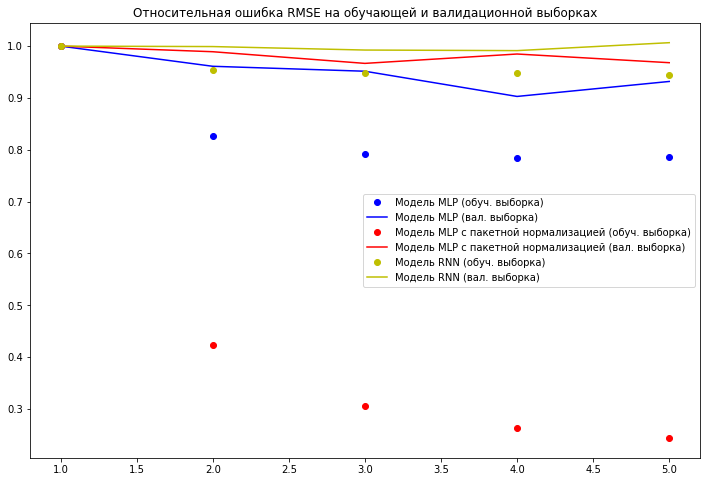

In [34]:
epochs = range(1, len(val_loss_rnn) + 1)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss_mlp, "bo", label="Модель MLP (обуч. выборка)")
plt.plot(epochs, val_loss_mlp, "b", label="Модель MLP (вал. выборка)")
plt.plot(epochs, loss_mlp_2, "ro", label="Модель MLP с пакетной нормализацией (обуч. выборка)")
plt.plot(epochs, val_loss_mlp_2, "r", label="Модель MLP с пакетной нормализацией (вал. выборка)")
plt.plot(epochs, loss_rnn, "yo", label="Модель RNN (обуч. выборка)")
plt.plot(epochs, val_loss_rnn, "y", label="Модель RNN (вал. выборка)")
plt.title("Относительная ошибка RMSE на обучающей и валидационной выборках")
plt.legend();

#### Задание 9
Визуализируйте весь набор данных и прогнозы трех построенных моделей для обучающей и тестовой выборок на одном рисунке (ось X – даты, ось Y – стоимость акции), подписывая оси и рисунок и создавая легенду. 
